# Hamilton filter

by **[Shunsuke Hori](https://github.com/Shunsuke-Hori) (University of California, San Diego, PhD Economics)**

Hodrick-Prescott (HP) filter is commonly used in economics to detrend time series variables. Recently, however, Hamilton (2017) shows "why you should never use the Hodrick-Prescott filter", which is actually the title of the paper, and proposes an alternative method.

`QuantEcon.jl` has functions of HP filter and Hamilton filter. I'm going to explain the usage of these functions and confirm some observations in the paper by simulations.

Reference:
[Hamilton, James D. "Why you should never use the Hodrick-Prescott filter." Review of Economics and Statistics 0 (2017)](http://econweb.ucsd.edu/~jhamilto/hp.pdf)

# Import packages

First thing to do is to import some packages.

(Note: I ran this cell twice just to reduce the size of the notebook. See [this issue](https://github.com/JuliaPlots/Plots.jl/issues/1724).)

In [2]:
using QuantEcon # for filters
using InfoZIP # to access CSV file in ZIP
using CSV # to read CSV file as DataFrame
using Plots # for plotting
pyplot() 
using StatsBase # for `autocor()`
using LaTeXStrings # for labels

In [3]:
using Pkg
pkg"status"

    Status `C:\Users\holly\.julia\environments\v1.0\Project.toml`
  [28f2ccd6] ApproxFun v0.9.0
  [336ed68f] CSV v0.3.1
  [60f91f6f] CovarianceMatrices v0.9.0
  [a93c6f00] DataFrames v0.13.1
  [0c46a032] DifferentialEquations v5.3.0
  [31c24e10] Distributions v0.16.4
  [c04bee98] ExcelReaders v0.10.2
  [38e38edf] GLM v1.0.1
  [28b8d3ca] GR v0.34.1
  [7073ff75] IJulia v1.11.1
  [f4508453] InfoZIP v0.2.0
  [b964fa9f] LaTeXStrings v1.0.2
  [39ec1447] Millboard v0.2.0
  [0db19996] NBInclude v2.1.0
  [76087f3c] NLopt v0.5.1
  [2774e3e8] NLsolve v2.1.0
  [429524aa] Optim v0.17.1
  [91a5bcdd] Plots v0.20.2
  [438e738f] PyCall v1.18.4
  [d330b81b] PyPlot v2.6.3
  [fcd29c91] QuantEcon v0.15.0
  [ee283ea6] Rebugger v0.1.4
  [f2b01f46] Roots v0.7.2
  [60ddc479] StatPlots v0.8.1
  [2913bbd2] StatsBase v0.25.0
  [bd07be1c] Winston v0.14.0
  [8bb1440f] DelimitedFiles 
  [10745b16] Statistics 


# Get Data

I'm going to use the same data with the original paper and replicate a figure.

First, download zip file from author's website.

In [4]:
download("http://econweb.ucsd.edu/~jhamilton/hp_replicate.zip",
         "data.zip")

"data.zip"

Next, extract files.

In [5]:
InfoZIP.unzip("data.zip");

Now, read the data file I want to use.

The data is seasonally adjusted and unadjusted quarterly nonfarm payrolls.

In [6]:
df = CSV.read("Matlab/employment.csv",
              header=["year", 
                      "payrolls_adj",
                      "payrolls_unadj"],
              allowmissing=:none)

,year,payrolls_adj,payrolls_unadj
1,1947.0,43606,43349
2,1947.25,43808,43764
3,1947.5,44201,44591
4,1947.75,44579,45514
5,1948.0,44681,44291
6,1948.25,45033,44951
7,1948.5,45295,45796
8,1948.75,45029,46074
9,1949.0,44238,43747
10,1949.25,43739,43668


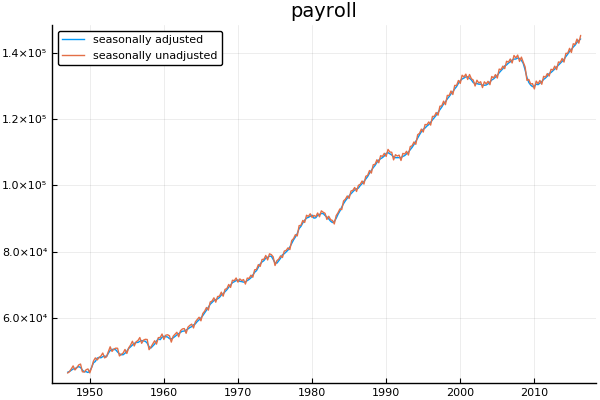

In [7]:
plot(df[:year], [df[:payrolls_adj] df[:payrolls_unadj]],
     title="payroll",
     lab=["seasonally adjusted" "seasonally unadjusted"])

# Apply HP and Hamilton filter
## HP filter
`hp_filter` needs two arguments: data and smoothing penalty parameter $\lambda$.

For this quarterly data, $\lambda=1600$ is used as smoothness penalty following the convention.

In [8]:
# apply to seasonally adjusted data
df[:payrolls_adj_hp_cyc], df[:payrolls_adj_hp] =
    hp_filter(log.(df[:payrolls_adj]), 1600)
# apply to seasonally unadjusted data
df[:payrolls_unadj_hp_cyc], df[:payrolls_unadj_hp] = 
    hp_filter(log.(df[:payrolls_unadj]), 1600)

([-0.00491899, 0.00021151, 0.0145376, 0.0306372, -0.000989706, 0.00938792, 0.0235477, 0.0250551, -0.0314411, -0.0381059  …  -0.00695789, 0.00767303, 0.00307368, 0.00925561, -0.00412865, 0.00968195, 0.00356796, 0.00995403, -0.0033127, 0.00819445], [10.682, 10.6864, 10.6907, 10.6951, 10.6995, 10.7039, 10.7084, 10.7129, 10.7176, 10.7225  …  11.8361, 11.8405, 11.845, 11.8496, 11.8542, 11.8589, 11.8637, 11.8684, 11.8732, 11.8779])

## Hamilton filter
Hamilton filter estimates
$$ y_{t+h}=\alpha+\beta_0y_t+\beta_1y_{t-1}+\dots+\beta_py_{p-1}+v_{t+h}$$
and the estimated $\hat{v}_{t+h}$ becomes the cyclical components.

$h$ is the time lag that you are likely to predict incorreactly. The author writes 2-year time horizon is standard for macro and financial time series variables. So, $h=8$ is used for the quarterly payroll data.

$p$ is the number of lags used. Larger $p$ means that the model is richer but also that you need to estimate more parameters, i.e. there is a larger difference between smal sample and asymptotic results.

Also, the paper notes that $h$ and $p$ should be multiples of number of samples in a single year for a data with seasonality.
Due to these considerations, Hamilton (2017) recommends $h=8$ and $p=4$ for quarterly data.

In [9]:
# apply to seasonally adjusted data
df[:payrolls_adj_ham_cyc], df[:payrolls_adj_ham] = 
    hamilton_filter(log.(df[:payrolls_adj]), 8, 4)
# apply to seasonally unadjusted data
df[:payrolls_unadj_ham_cyc], df[:payrolls_unadj_ham] = 
    hamilton_filter(log.(df[:payrolls_unadj]), 8,4)

([NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  0.00887052, 0.0107435, 0.013445, 0.0160916, 0.0160677, 0.0151016, 0.015896, 0.0192038, 0.0196752, 0.014017], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  11.8202, 11.8374, 11.8346, 11.8427, 11.834, 11.8535, 11.8513, 11.8592, 11.8502, 11.8721])

## Hamilton filter assuming random walk

If you believe the model is random walk, you should pass only $h$ as a second argument. Then, cyclical component is estimated as $y_{t+h}-y_t$.

In [10]:
# apply to seasonally adjusted data
df[:payrolls_adj_ham_rw_cyc], df[:payrolls_adj_ham_rw] = 
    hamilton_filter(log.(df[:payrolls_adj]), 8)
# apply to seasonally unadjusted data
df[:payrolls_unadj_ham_rw_cyc], df[:payrolls_unadj_ham_rw] = 
    hamilton_filter(log.(df[:payrolls_unadj]), 8)

([NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 0.0091394, -0.00219599  …  0.0312139, 0.0350727, 0.0364916, 0.0386862, 0.0376747, 0.0392344, 0.0387936, 0.0412511, 0.0407651, 0.0379962], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 10.677, 10.6866  …  11.7979, 11.8131, 11.8116, 11.8201, 11.8124, 11.8294, 11.8284, 11.8371, 11.8291, 11.8481])

# Replication

The following figure replicate Figure 5 of the original paper (Regression and 8-quarter-change filters app
lied to seasonally adjusted and seasonally 
unadjusted employment data)

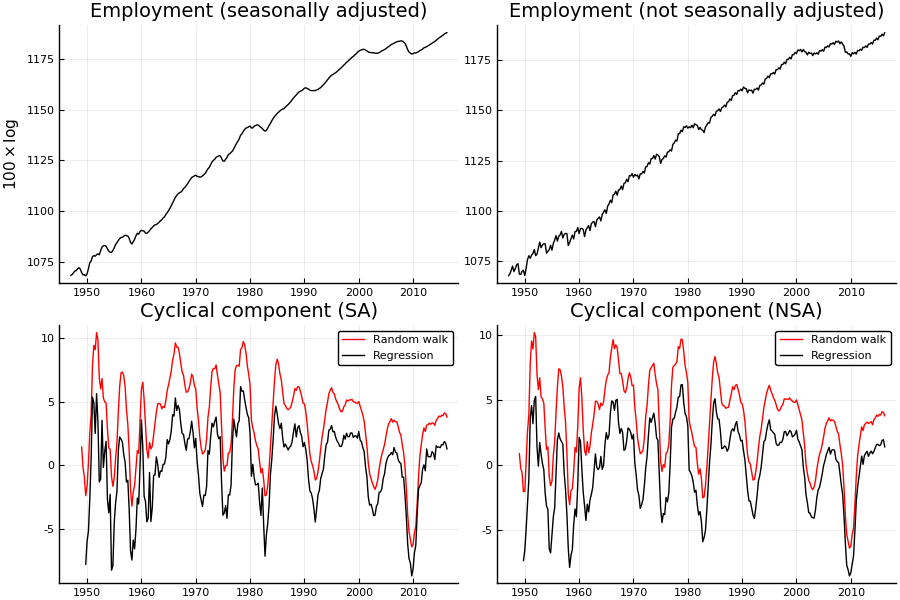

In [11]:
p = plot(layout=(2, 2), size=(900, 600),
         title=["Employment (seasonally adjusted)" "Employment (not seasonally adjusted)" "Cyclical component (SA)" "Cyclical component (NSA)"],)
plot!(p[1], df[:year], 100*log.(df[:payrolls_adj]),
     yaxis = L"100\times\log",
     leg=nothing, lc=:black)
plot!(p[2], df[:year], 100*log.(df[:payrolls_unadj]),
     leg=nothing, lc=:black)
plot!(p[3], df[:year], 
     100*[df[:payrolls_adj_ham_rw_cyc] df[:payrolls_adj_ham_cyc]],
     lab=["Random walk" "Regression"],
     legend=:topright, lc=[:red :black])
plot!(p[4], df[:year], 
     100*[df[:payrolls_unadj_ham_rw_cyc] df[:payrolls_unadj_ham_cyc]],
     lab=["Random walk" "Regression"],
     legend=:topright, lc=[:red :black])

The regression based cycle component has sample mean zero because the regression includes constant term. In contrast, under random walk assumption, sample mean of cyclical movements is average growth rate over a two-year because I chose $h=8$.

# Comparison

The following figure plots cyclical components estimated by 
HP filter and Hamilton filter.

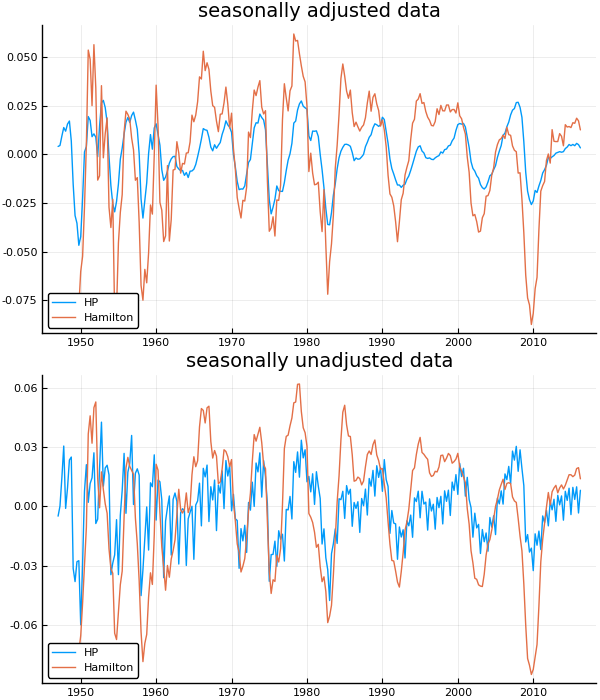

In [12]:
p = plot(layout=(2, 1), size=(600, 700))
plot!(p, df[:year], 
     [df[:payrolls_adj_hp_cyc] df[:payrolls_unadj_hp_cyc] df[:payrolls_adj_ham_cyc] df[:payrolls_unadj_ham_cyc]],
     lab=["HP" "HP" "Hamilton" "Hamilton"],
     title=["seasonally adjusted data" "seasonally unadjusted data"],
     legend=:bottomleft)

# When should we use HP filter?

Short answer: **_Never_**.

## Random walk

Consider a random walk model: $y_t=y_{t-1}+c_t$ where $c_t$ is the white noise and cyclical component in this model. 

I'll simulate the random walk process and see the autocorrelation of estimated cyclical term by HP.

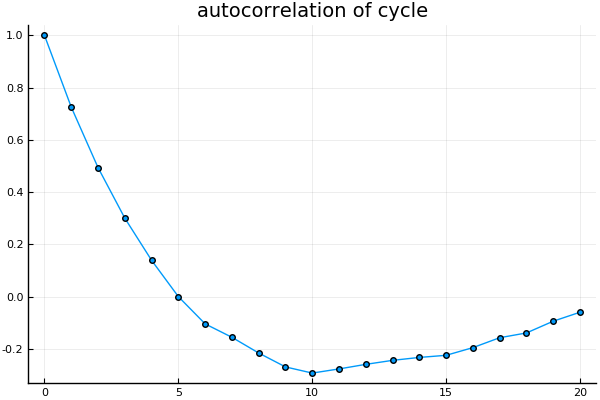

In [13]:
# simulate random walk process
T = 1000
c = randn(T)
y = cumsum(c)

# apply filter
y_hp_c, y_hp_t = hp_filter(y, 1600)

# plot autocorrelation
plot(0:20, autocor(y_hp_c, 0:20), leg=nothing,
    markershape=:circle, title="autocorrelation of cycle")

Note that the autocorrelation of cyclical component should be zero for any lag because cyclical component $c_t$ is independent over $t$.

However, estimated cyclical component by HP filter is highly predictable.

### Hamilton filter with random walk assumption

If you believe the process is random walk, you should use `hp_filter` with $h$ which is the time horizon that we are likely to predict incorrectly.

In the case of $y_t=y_{t-1}+c_t$, even if $y_{t-1}$ is observed, it does not help predicting $y_{t}$, so $h=1$.

In [14]:
y_cycle, y_trend = hamilton_filter(y, 1)

all(isapprox.(c[2:end], y_cycle[2:end]))

true

Above cell confirms that the estimated cyclical components are equal to $c_t$ (up to numerical error).

## Special case in which HP filter seems to work

Suppose we know the following state-space representation is the true DGP:
$$y_t=g_t+c_t$$
$$g_t=2g_{t-1}-g_{t-2}+v_t=g_{t-1}+(g_{t-1}-g_{t-2})+v_t$$
where $c_t$ and $v_t$ are uncorrelated white noise process with variance $\sigma_c^2$ and $\sigma_v^2$.

According to the Proposition 1 in the paper, as the variance of $(g_0,g_{-1})$ becomes large, HP filter with $\lambda=\frac{\sigma_c^2}{\sigma_v^2}$ tends to be identical to find optimal linear prediction of a trend. ("optimal" in the sense of minimum expected squared error)

In [15]:
T=1000
sigmac = 5
sigmav = 1/8
g = zeros(T)
c = sigmac*randn(T)
v = sigmav*randn(T)
glag1 = randn()
glag2 = randn()
g[1] = 2*glag1-glag2+v[1]
g[2] = 2*g[1]-glag1+v[2]
for t=3:T
    g[t] = 2*g[t-1]-g[t-2]+v[t]
end
y = g + c

1000-element Array{Float64,1}:
     1.7519576470100828 
    -4.089576606201658  
     0.8756452859155892 
    -6.096950731338014  
     4.61137848220789   
    -3.1526864262707974 
    11.720344537993569  
    -4.113979432139601  
     4.770561323365059  
    -2.4603213007080007 
     5.418680190442104  
    -0.07178314324856705
    -1.2609928295551518 
     ⋮                  
 -3403.920805062765     
 -3416.3977682703703    
 -3407.998482076389     
 -3426.4522468978125    
 -3428.064234109206     
 -3423.976743998953     
 -3436.7437039747856    
 -3447.1292484849278    
 -3441.0128835190685    
 -3451.482061890094     
 -3454.062818882299     
 -3457.363047031691     

The above parameterization of $\sigma_c$ and $\sigma_v$ yields the famous value of $\lambda$.

In [16]:
lambda = sigmac^2/sigmav^2

1600.0

Now, let's confirm that the estimated cyclical component is white noise as noted in the paper.

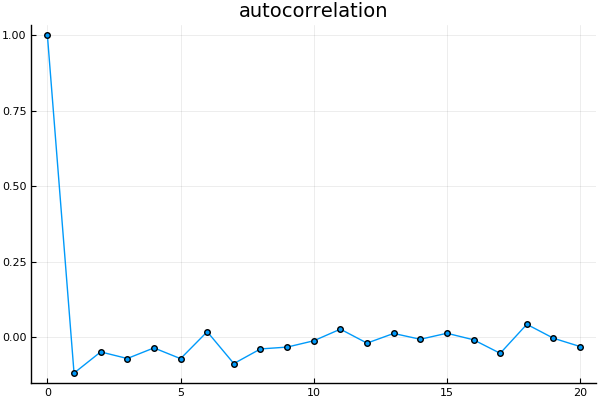

In [17]:
# Apply HP filter
y_hp_c, y_hp_t = hp_filter(y, lambda)

# plot autocorrelation
plot(0:20, autocor(y_hp_c, 0:20), 
     title="autocorrelation", markershape=:circle, leg=nothing)

Yes, the cyclical component obtained by HP filter is unpredictable.

What does it mean? It means that we cannot do any investigation into the cyclical components because they are independent. There is no cyclicality in this "cyclical" component.

Moreover, if the model is true, we can estimate $\sigma_c$ and $\sigma_v$ using (quasi-)MLE. The Table 1 in the paper reports several estimates for macroeconomic serieses, implying that $\sigma_c^2$ is not 1600 times larger than $\sigma_v^2$.

# Properties of Hamilton filter in some settings

## Random walk

Even if you don't know anything about the process, you can get  sensible estimates of cyclical component using `hp_filter` with three arguments: data, $h$, and $p$.

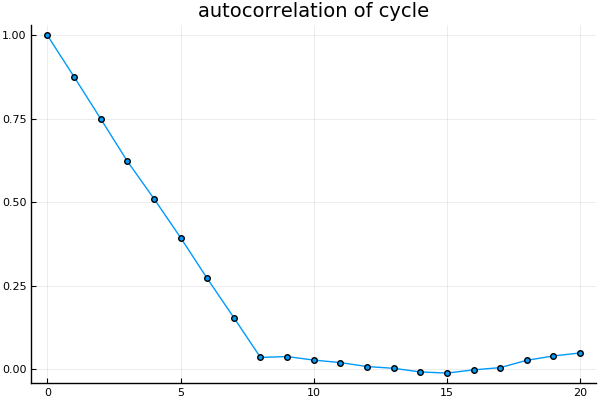

In [18]:
# simulate random walk process
T = 1000
c = randn(T)
y = cumsum(c)

# apply Hamilton filter (without random walk assumption)
y_cycle, y_trend = hamilton_filter(y, 8, 4)

plot(0:20, autocor(y_cycle[13:end], 0:20), # first 12 observations are missing
    markershape=:circle, title="autocorrelation of cycle", leg=nothing)

As shown in  section 4.2 of the paper, the estimates of cyclical term is 
$$y_{t+h}-y_{t}=c_{t+h}+c_{t+h-1}+\dots+c_{t+1}=\sum_{s=t+1}^{t+h}c_s$$
when sample size is large enough. Thus, autocorrelation of $\tau$ lag is
$$\frac{Cov\left(\sum_{s=t+1}^{t+h}c_s, \sum_{s=t+1+\tau}^{t+h+\tau}c_s\right)}{Var\left(\sum_{s=t+1}^{t+h}c_s\right)},$$
which is zero for $t>h$.

If you compare the estimation error of cyclical components, you'll notice Hamilton filter performs much better than HP filter.

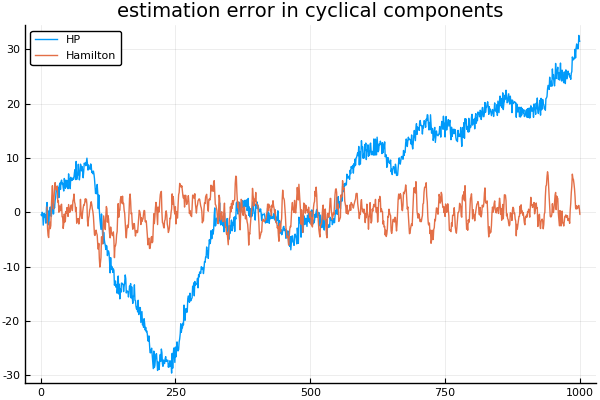

In [19]:
y_hp_c, y_hp_t = hp_filter(y, 1600)
plot(1:T, [c-y_hp_t c-y_cycle], lab=["HP" "Hamilton"],
     title="estimation error in cyclical components")

## Deterministic time trend

Consider $y_t = \delta_0+\delta_1 t+\epsilon_t$. Section 4.2 of the paper shows that the true trend is well approximated by Hamilton filter as sample size increases

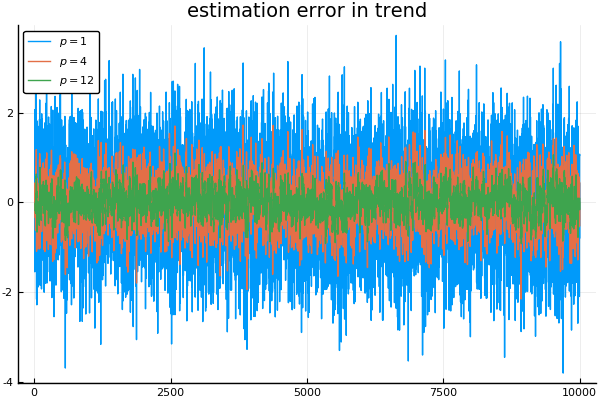

In [20]:
# simulate deterministic time trend process
T = 10000
epsilon = randn(T)
delta0 = 0
delta1 = 0.02/4
trend = delta0 .+ delta1*(1:T)
y = trend + epsilon

error_p1 = hamilton_filter(y, 8, 1)[2] - trend
error_p4 = hamilton_filter(y, 8, 4)[2] - trend
error_p8 = hamilton_filter(y, 8, 12)[2] - trend
plot(1:T, [error_p1 error_p4 error_p8], lab=[L"p=1" L"p=4" L"p=12"],
     title="estimation error in trend")

As expected, the estimate with higher $p$ gives better prediction of trend. 

Keep in mind that larger sample size is required for large $p$. With small sample, small $p$ seems to be better.

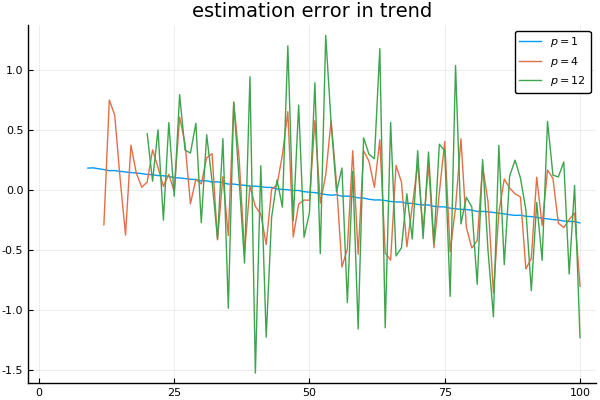

In [21]:
T_small = 100
y, trend = y[1:T_small], trend[1:T_small]
error_p1 = hamilton_filter(y, 8, 1)[2] - trend
error_p4 = hamilton_filter(y, 8, 4)[2] - trend
error_p8 = hamilton_filter(y, 8, 12)[2] - trend
plot(1:T_small, [error_p1 error_p4 error_p8], lab=[L"p=1" L"p=4" L"p=12"],
     title="estimation error in trend")